# PHYS 381 - Assignment 5#
### (Assignment 3 Resubmission)
### Siegfried Peschke - 30032136
#### March 28, 2019

## Introduction

This is a reiteration of assignment 3. The task was misunderstood and the expected analysis was not performed. In this assignment we will correctly analyze the driven damped harmonic oscillator using numerical methods.

From https://en.wikipedia.org/wiki/Harmonic_oscillator we take Newtons second law for a driven simple harmonic oscillator written as

$$ \frac{\mathrm{d}^2x}{\mathrm{d}t^2} + 2\zeta\omega_0\frac{\mathrm{d}x}{\mathrm{d}t} + \omega_0^2 x = \frac{F(t)}{m} $$

Now take the driving force to be $F(t) = F_0\cos(\omega t)$. This yields the steady-state solution

$$ x(t) = \frac{F_0}{m Z_m \omega} \cos(\omega t + \varphi) $$

where

$$ Z_m = \sqrt{\left(2\omega_0\zeta\right)^2 + \frac{1}{\omega^2} (\omega_0^2 - \omega^2)^2} $$

and

$$ \varphi = \arctan\left(\frac{2\omega \omega_0\zeta}{\omega^2 - \omega_0^2} \right) + n\pi $$

The amplitude of the steady-state solution is then given by

$$ A = \frac{F_0}{m Z_m \omega} = \frac{F_0}{m}\left(\left(2\zeta\frac{\omega_0}{\omega}\right)^2 + \left(\left(\frac{\omega_0}{\omega}\right)^2 - 1\right)^2\right)^{-\frac{1}{2}} $$

The maxima curve which establishes the maximum frequency response for a given damping ratio and is given by

$$ A = \frac{1}{\sqrt{1-\left(\frac{\omega}{\omega_0}\right)^4}} $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import unicodedata

## Task 1 - Integrate the ODE with scipy.integrate.odeint and generate the plot of the steady-state amplitude of the damped driven harmonic oscillator with different damping ratios

Let us first create a function which evaluates the analytic amplitude of the steady-state solution given in the introduction and another which creates the maxima curve.

In [2]:
def theoretical_amplitude(omega, zeta, omega_0 = 1):
    beta = omega / omega_0
    return 1 / np.sqrt((2*beta*zeta)**2 + (beta**2-1)**2)

def maxima_curve(omega, omega_0 = 1):
    return 1 / np.sqrt(np.abs(1-(omega/omega_0)**4))

In order to allow scipy.integrate.odeint to evaluate the differential equation, let us introduce an independent variable in order to turn the second order equation into two first order equations.

Define the system of equations $y = [x', x]$ and $y' = [x'', x']$

From Newtons second law we have
$$ \frac{d^2x}{dt^2} = \frac{F_0}{m}\cos(\omega t) - 2\zeta\omega_0\frac{dx}{dt} - \omega_0^2 x$$

so the system becomes

$$ y'[0] = \frac{F_0}{m}\cos(\omega t) - 2\zeta\omega_0\frac{dx}{dt} - \omega_0^2 x$$

$$ y'[1] = y[0] $$

Let us create a function that returns system of equations.

In [3]:
def dy_dx(y0, t, zeta, omega, omega_0 = 1.0, F_0 = 1.0, m = 1.0):
    x, v = y0
    return [v, F_0*np.cos(omega*t)/m - 2*zeta*v - (omega_0**2)*x]

Now let us create a function which determines the maximum amplitude of the steady-state solution at a given driving frequency.

In [4]:
def max_amplitude(y0, t, zeta, omega):
    positions = []
    states = odeint(dy_dx, y0, t, args = (zeta, omega))[499:]
    for entry in states:
        positions.append(np.abs(entry[0]))
    if zeta == 0.0:
        return np.max(positions)/2 #Take half amplitude for undamped case
    else:
        return np.max(positions)

Since the solution to the differential equation is a combination of transient and steady-sate, in order to properly analyze steady-state amplitudes, we should find at what time the oscillator reaches it's steady state. We can do this by finding what time the transient motion is sufficiently small to be negligble, at this point the steady-state has been reached. The transient solution to the damped harmonic oscillator is given by

$$ x(t) = \begin{cases}
 \mathrm{e}^{-\zeta t} \left( c_1 \mathrm{e}^{t \sqrt{\zeta^2 - 1}} + c_2 \mathrm{e}^{- t \sqrt{\zeta^2 - 1}} \right) & \zeta > 1 \text{ (overdamped)} \\
 \mathrm{e}^{-\zeta t} (c_1+c_2 t) = \mathrm{e}^{-t}(c_1+c_2 t) & \zeta = 1 \text{ (critically damped)} \\
 \mathrm{e}^{-\zeta t} \left( c_1 \cos \left(\sqrt{1-\zeta^2} t\right) + c_2 \sin\left(\sqrt{1-\zeta^2} t\right) \right) & \zeta < 1 \text{ (underdamped)} \\
 C & \zeta = 0 \text{ (undamped)}
\end{cases} $$

We can see that for all damped cases, the exponential term $\mathrm{e}^{-\zeta t}$ governs the amplitude. Therefore we will create a function that finds the time at which this term is sufficiently small so that it can be ignored. In other words, find the time at which the transient contribution to the ampltidue is negligible. Then create a function which finds the steady state time

In [5]:
def transient_state_time(zeta, f = 1e-16):
    return np.log(f) / (-1*zeta)

def steady_state_time(zeta_list):
    steady_t = 0
    for zeta in zeta_list:
        if zeta == 0:
            pass
        else:
            transient_t = transient_state_time(zeta)
            if transient_t > steady_t:
                steady_t = transient_t
    return steady_t

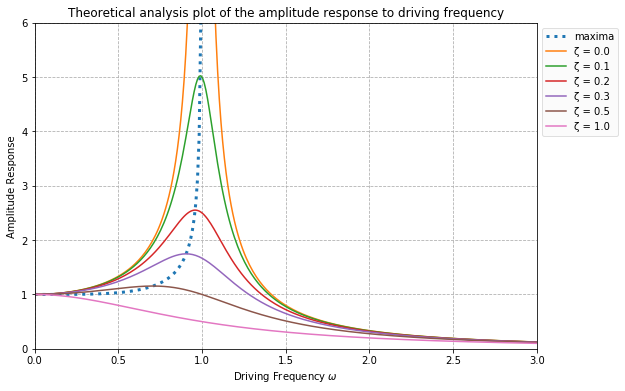

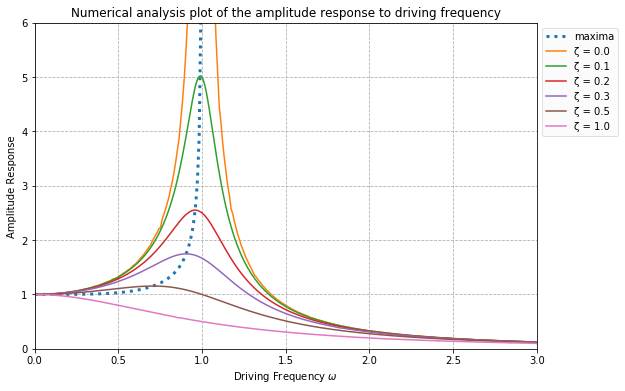

In [6]:
#Data
y0 = [0.0, 0.0] #Initial conditions
zeta_zero = True
zeta_list = [0.0, 0.1, 0.2, 0.3, 0.5, 1.0]
w = np.linspace(0, 3, 300) #Varying driving frequency

#Analytic Analysis Plot
#Gridlines
plt.figure(figsize=(9,6))
plt.axis([0, 3, 0, 6])
plt.grid(linestyle='dashed')
#Labels
plt.xlabel('Driving Frequency $\omega$')
plt.ylabel('Amplitude Response')
plt.title("Theoretical analysis plot of the amplitude response to driving frequency")

#Plot Maxima Curve
plt.plot(w[:100], maxima_curve(w[:100]), ':', label = 'maxima', linewidth = 3)

#Plot the data points
for zeta in zeta_list:
    plot_name = '\u03B6 = ' + str(zeta)
    plt.plot(w, theoretical_amplitude(w, zeta), label = plot_name)

#Legend
legend = plt.legend(bbox_to_anchor=(1, 1), loc=2)
frame = legend.get_frame()
frame.set_facecolor('#f9f9f9')
frame.set_alpha(0.6)
    
plt.show()

#Numerical Analysis Plot
#Gridlines
plt.figure(figsize=(9,6))
plt.axis([0, 3, 0, 6])
plt.grid(linestyle='dashed')
#Labels
plt.xlabel('Driving Frequency $\omega$')
plt.ylabel('Amplitude Response')
plt.title("Numerical analysis plot of the amplitude response to driving frequency")

#Create the time domain
t = np.linspace(0, int(steady_state_time(zeta_list))*2, 999)

#Plot Maxima Curve
plt.plot(w[:100], maxima_curve(w[:100]), ':', label = 'maxima', linewidth = 3)

#Plot Damped Amplitude Response
for zeta in zeta_list:
    amplitudes = []
    for omega in w:
        amplitudes.append(max_amplitude(y0, t, zeta, omega))
    plot_name = '\u03B6 = ' + str(zeta)
    plt.plot(w, amplitudes, label = plot_name)        

#Legend
legend = plt.legend(bbox_to_anchor=(1, 1), loc=2)
frame = legend.get_frame()
frame.set_facecolor('#f9f9f9')
frame.set_alpha(0.6)
    
plt.show()

From the plot we can clearly see that as the damping ratio increases amplitude response becomes flatter for varying driving frequencies. This allows us to conclude that we may use damping to decrease the amplitude response at the resonant frequency, as seen for $\zeta = 0.5$, the amplitude response is fairly flat. Something of note for the plot is that when we vary $\omega_0$ we find that the resonant frequency for the undamped oscillator shifts to be exactly $\omega_0$.

## Task 2 - Integrate the ODE with scipy.integrate.odeint and plot for varying driving frequencies and damping rates

We can use the function scipy.integrate.odeint directly on the function dy_dx in order to find a solution to the ODE. We can do this for varying damping rates and driving frequencies and plot them against each other to analyze the effect on the system.

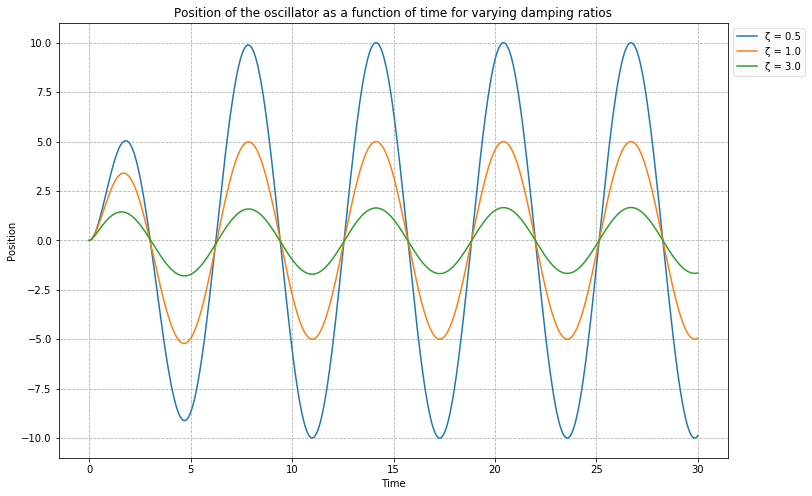

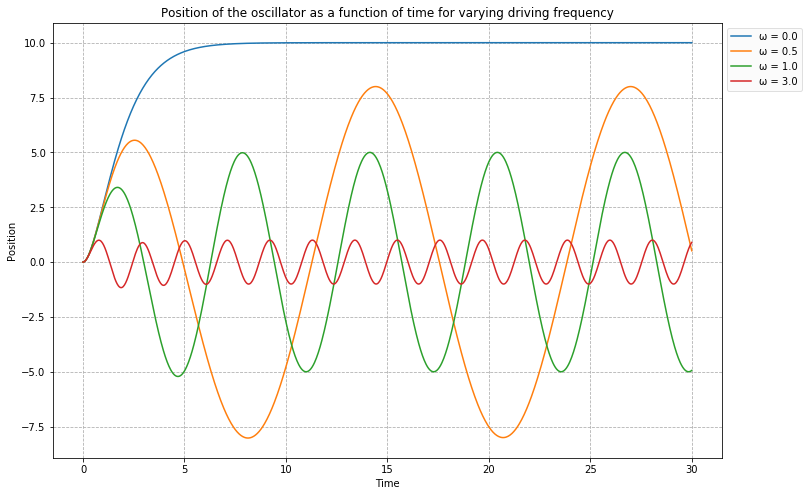

In [7]:
#Data
y0 = [0.0, 0.0] #Initial conditions - position and velocity
omega_0 = 1.0
F_0 = 10.0
zeta_list = [0.5, 1.0, 3.0]
omega_list = [0.0, 0.5, 1.0, 3.0]

#Plot for varying damping rates at a constant driving frequency
#Create the domain
t = np.linspace(0, 30, 1000)

#Gridlines
plt.figure(figsize=(12,8))
plt.grid(linestyle='dashed')
#Labels
plt.xlabel('Time')
plt.ylabel('Position')
plt.title("Position of the oscillator as a function of time for varying damping ratios")

#Plot the function
for zeta in zeta_list:
    w = 1.0 #Set constant driving frequency
    plot_name = '\u03B6 = ' + str(zeta)
    y = odeint(dy_dx, y0, t, args = (zeta, w, omega_0, F_0))[:,0]
    plt.plot(t, y, label = plot_name)

#Legend
legend = plt.legend(bbox_to_anchor=(1, 1), loc=2)
frame = legend.get_frame()
frame.set_facecolor('#f9f9f9')
frame.set_alpha(0.6)

plt.show()

#Plot for varying driving frequency at a constant damping rate
#Create the domain
t = np.linspace(0, 30, 1000)

#Gridlines
plt.figure(figsize=(12,8))
plt.grid(linestyle='dashed')
#Labels
plt.xlabel('Time')
plt.ylabel('Position')
plt.title("Position of the oscillator as a function of time for varying driving frequency")

#Plot the function
for omega in omega_list:
    z = 1.0 #Set constant damping rate
    plot_name = '\u03C9 = ' + str(omega)
    y = odeint(dy_dx, y0, t, args = (z, omega, omega_0, F_0))[:,0]
    plt.plot(t, y, label = plot_name)

#Legend
legend = plt.legend(bbox_to_anchor=(1, 1), loc=2)
frame = legend.get_frame()
frame.set_facecolor('#f9f9f9')
frame.set_alpha(0.6)

plt.show()

Analytically, if we look at the equation for the amplitude in the introduction, we expect that the larger the damping ratio, $\zeta$, the smaller the amplitude response. The amplitude response of increasing the driving frequency is shown in task 1. Looking at the steady-state solution given in the introduction we expect that varying the damping ratio has no effect on the period and increasing the driving frequency decreases the period.

When we increase the damping force, we find that the period of oscillation remains the same, as shown by the time at which the oscillator reaches a peak in amplitude. The amplitude of oscillation decreases as the damping force increases. This is consistent with both our intuition of the effect of a damping force as well as the prediction of the analytical steady-state solution.

When we increase the driving frequency, we find that the period of oscillation grows smallers, as expected. For a driving frequency of zero, there is basically no amplitude response of the oscillator and for the driving frequency of $w = 3.0$ we see a small amplitude response, yet for an inbetween value such as $\omega = 0.5$ we see a large amplitude response. We conclude that the driving frequency increases amplitude from 0 up to a specific frequency, then it begins to decrease the amplitude as the driving frequency is further increased. This is consistent with the plot in task 1.

Therefore we find that using scipy.integrate.odeint yields a solution which follows expected results.

## Conclusion

In this assignment we explore the driven harmonic oscillator. We explore the amplitude response to the driving frequency for different damping ratios and find that the greater the damping force the smaller the amplitude of the oscillator. To follow this up we utilize scipy.integrate.odeint in order to find a solution to the differential equation resulting from Newtons second law, given in the introduction. We then use this solution and vary the damping force whilst keeping the driving force constant, then vary the driving force and keep the damping force constant. We find the results agree with our intuition and analytic expectations.